In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, random

import sklearn
from sklearn import ensemble, model_selection, preprocessing, tree, linear_model, neighbors
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

## In Summary:
    - several models were run to predict the converted column
        - each model was run both with and without the score column to test the difference 
    - running the model with the score column improved "correctness" of the model
        - however, since the data is collected as a snapshot of the past 30 days (according to the days since column),
            it may be reasonable to accept a model that predicts a false positive, or a YES for converted when the current
            30 day snapshot of the data shows it's currently a NO for converted
        - unfortunately, models that had somewhat of an encouraging false positive, generally had more false negatives.
            - that said, because false negatives have in fact already converted, false negatives may not be an issue.
            
        - The following models had the highest rates of false positives (YES when the current data shows NO):
            - KNN Classifier (without score) -- n=1200+
            - KNN Regressor (without score) -- n=1000+
            - Random Forest (without score) -- n=750+
            

### I'm using  plot_confusion_matrix  function taken from kernel found on Kaggle
####  Credit to [George Fisher](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/notebook) who has licensed it under an [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0)  open source license

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### A function for pickling the classifiers (not necessary)

In [3]:
def pickle_classifier(filepath, classifier):
    """Function to automate the pickling of a classifier
    """
    with open(filepath, 'wb') as f:
        pickle.dump(classifier, f)

def load_pickled_classifier(filepath):
    """Function to load a pickled classifier
    """
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [29]:
df = pd.read_json('..\\data\\cleaned_df_categorical_columns.json')

# convert categorical to binary value
df_w_dummies = pd.get_dummies(df)

# moving converted to last column (was thinking of using random.shuffle)
df_score = df_w_dummies['score']
df_w_dummies = df_w_dummies.drop(['score'], axis=1)
df_w_dummies['score'] = df_score

In [36]:
df_w_dummies.head()

df = df_w_dummies.astype(float)

### Random Forest

Test 1 Accuracy:	0.86876


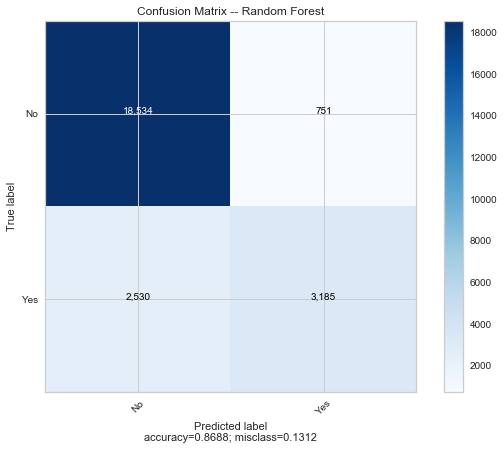

In [93]:
# without score

X = df.drop(columns=['converted', 'score'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    n_trees = 500
    clf = ensemble.RandomForestClassifier(max_features='auto', n_estimators=n_trees, random_state=None, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\random_forest_categorical_wo_score.pickle', clf)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Random Forest")

Test 1 Accuracy:	1.0


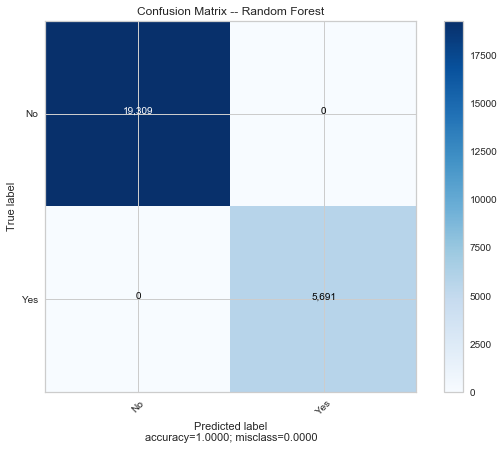

In [94]:
# with score

X = df.drop(columns=['converted'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    n_trees = 500
    clf = ensemble.RandomForestClassifier(max_features='auto', n_estimators=n_trees, random_state=None, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\random_forest_categorical_w_score.pickle', clf)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Random Forest")

In [95]:
# print(clf.decision_path(X))
# print(clf.feature_importances_)

## Logistic Regression

Test 1 Accuracy:	0.86024
[-1.20935194 -1.13907928 -2.28597508 ... -2.33859157 -2.35647607
 -0.03560979]
-1.451293991012426


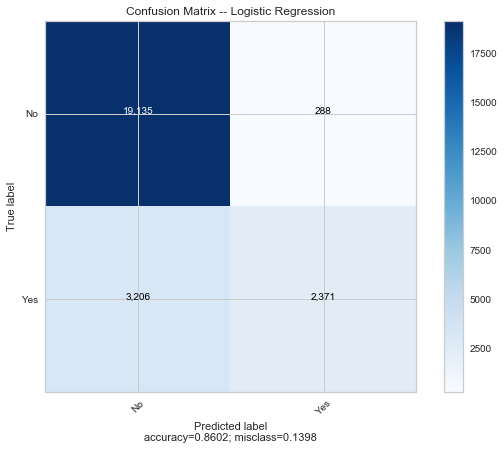

In [96]:
# without score
X = df.drop(columns=['converted', 'score'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LogisticRegression(random_state=None, solver='lbfgs', n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\logistic_regression_categorical_wo_score.pickle', clf)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(clf.decision_function(X))
print(clf.decision_function(X).mean())
pd.DataFrame(clf.decision_function(X)>0).describe()

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Logistic Regression")

Test 1 Accuracy:	0.99268
[  1.14718518  -1.42519854 -15.12136795 ... -18.63659701 -19.69403325
  12.01686989]
-10.539883726189093


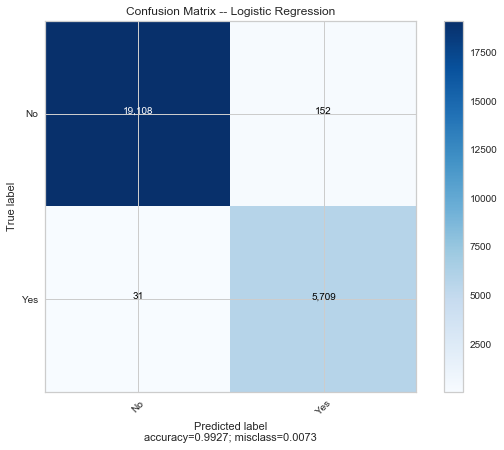

In [97]:
# with score
X = df.drop(columns=['converted'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LogisticRegression(random_state=None, solver='lbfgs', n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\logistic_regression_categorical_w_score.pickle', clf)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(clf.decision_function(X))
print(clf.decision_function(X).mean())
pd.DataFrame(clf.decision_function(X)>0).describe()

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Logistic Regression")

## Linear Regression

Test 1 Accuracy:	0.3279241013020544


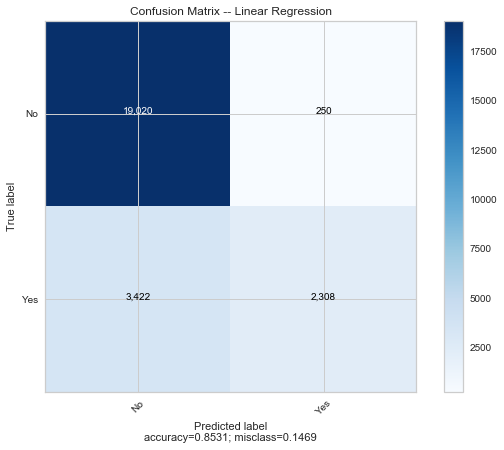

In [98]:
# without score
X = df.drop(columns=['converted', 'score'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\linear_regression_categorical_wo_score.pickle', clf)

y_pred = clf.predict(X_test)
y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Linear Regression")

Test 1 Accuracy:	0.4788738896710369


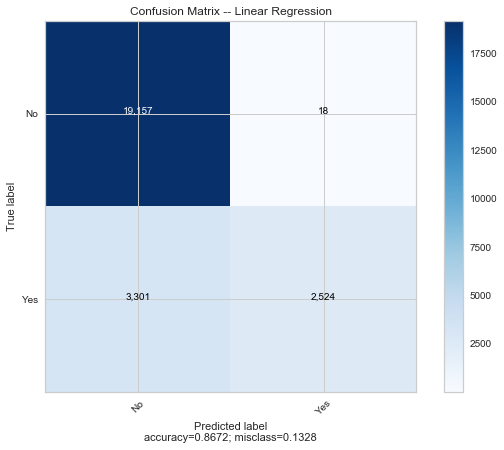

In [99]:
# with score
X = df.drop(columns=['converted'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\linear_regression_categorical_w_score.pickle', clf)

y_pred = clf.predict(X_test)
y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Linear Regression")

## K Nearest Neighbor (KNN)

#### KNN Regressor

Test 1 Accuracy:	0.28330820673923895


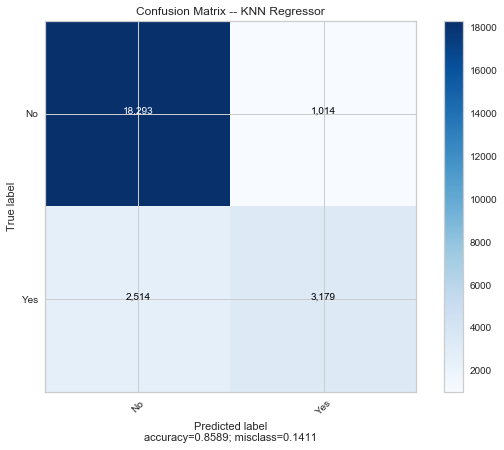

In [104]:
# without score
X = df.drop(columns=['converted', 'score'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_regressor_categorical_wo_score.pickle', clf)

y_pred = clf.predict(X_test)
y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Regressor")

Test 1 Accuracy:	0.9984432821622781


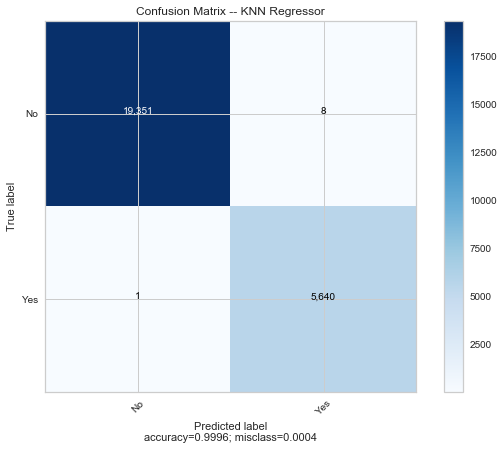

In [105]:
# with score
X = df.drop(columns=['converted'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_regressor_categorical_w_score.pickle', clf)

y_pred = clf.predict(X_test)
y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Regressor")

#### KNN Classifier

Test 1 Accuracy:	0.85376


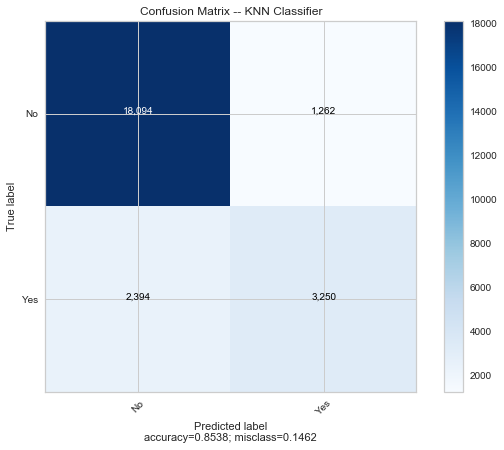

In [102]:
# without score
X = df.drop(columns=['converted', 'score'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_classifier_categorical_wo_score.pickle', clf)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Classifier")

Test 1 Accuracy:	0.99956


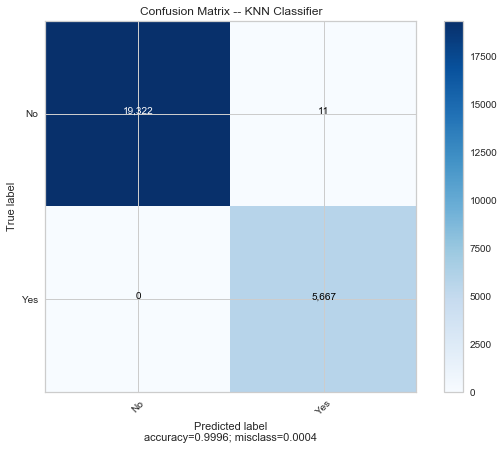

In [103]:
# with score
X = df.drop(columns=['converted'])
y = df.converted

for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_classifier_categorical_w_score.pickle', clf)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Classifier")